# Part 2 - Using a Class and Its Methods

## Exercising methods of the `Fuel` class

In this section, we’ll move from testing single equations to testing behaviors of class objects.

We’ll use the `Fuel` class, `FireParams`, and `FireEquations` from our source code. We will also introduce our "synthetic" fuels, which can be used to quickly mock up fuel objects that are based in reality, but have known conditions for more straightforward testing.

---

## Goals

* Instantiate `Fuel` objects based in reality, but with basic, standardized characteristics
* Test methods of the `Fuel` class
* Visualize outputs.
  
---

## Key Concepts

* **Synthetic inputs**: Create simple, controlled examples to explore expected behavior.

---

## Exercise 2.1: Set up `Fuel` object

Check out the code in the `fuel_class.py` file. This file contains our `Fuel` class:

```python
class Fuel:
    """Represents fuel characteristics of a patch of land"""

    def __init__(self, params: FireParams) -> None:
        """Initialize a new Fuel instance.

        Args:
            params (FireParams): parameters
        """
        self.params = params
        self.loading = np.zeros(NUM_FUEL_CLASSES, dtype=float)
        self.effective_moisture = np.zeros(NUM_FUEL_CLASSES, dtype=float)
        self.frac_loading = np.zeros(NUM_FUEL_CLASSES, dtype=float)
        self.frac_burnt = np.zeros(NUM_FUEL_CLASSES, dtype=float)
        self.non_trunk_loading = 0.0
        self.average_moisture_notrunks = 0.0
        self.bulk_density_notrunks = 0.0
        self.sav_notrunks = 0.0
        self.mef_notrunks = 0.0
```

This class houses characteristics of fuel for a patch of land that we are interested in, including amount of fuel (`loading`, kgC m$^{-2}$), moisture (`effective_moisture`, m$^3$ m$^{-3}$), fraction burnt (`frac_burnt`), bulk density (`bulk_density_notrunks`, kg m$^{-3}$), and surface area to volume ratio (`sav_no_trunks`, cm$^{-1}$).

There are also methods for the `Fuel` class, like `update_loading`, `compute_moisture`, and `average_bulk_density_no_trunks`.

### More about fuel

In the Rothermel fuel model, surface fuel is broken up by size, as this is one of the primary characteristics that effects fire behaviour:

#### Fuel classes
1. "1-hour" fuels (i.e., dead leaves)
2. "10-hour" fuels (i.e., twig litter)
3. "100-hour" fuels (i.e., branch litter)
4. "1000-hour" fuels (i.e., downed trunks)
5. live herbaceous fuel (i.e., grasses)

In the FATES code, we additionally break the branch litter up into small and large branches, thus representing six total fuel classes. Notice that some of the `Fuel` object attributes are (size 6) arrays, but some are scalars. The arrays hold values for each fuel class, whereas the scalars represent weighted-averages across the fuel classes.

<div class="alert alert-block alert-info"><b>Note: </b> Trunks are not used to calculate rate of spread, but we are interested in how much they may burn. As such, our weighted-average scalars do not include trunks in the averaging, but we still want to capture information about them in our arrays.</div>

---

### Instatiating the `Fuel` object

Alright, let's go ahead and instantiate an instance of the `Fuel` class. We need parameter values from our `FireParams` class. We can just go head and read in the default parameter file.

In [64]:
from fire_model.fire_params import FireParams
from fire_model.fuel_class import Fuel

# read in parameter file
params = FireParams.from_yaml("../parameter_files/fire_parameters.yaml")

# instantiate a fuel object
fuel = Fuel(params)

# print out fuel attributes
fuel.describe()

Fuel instance state:
  Loading (kgC/m2): [0. 0. 0. 0. 0. 0.]
  Effective moisture (m3/m3): [0. 0. 0. 0. 0. 0.]
  Fractional loading: [0. 0. 0. 0. 0. 0.]
  Fraction burnt: [0. 0. 0. 0. 0. 0.]
  Non-trunk loading (kgC/m2): 0.0000
  Avg moisture (non-trunks, m3/m3): 0.0000
  Bulk density (non-trunks, kg/m3): 0.0000
  SAV (non-trunks, /cm): 0.0000
  MEF (non-trunks, m3/m3): 0.0000


By design, all the `Fuel` attributes are initialized to zero. In order to do much of anything interesting, we will need to populate the values.

<div class="alert alert-block alert-warning">When you are using an instantiated object, make sure the attributes you are using are initialized to some value you want. </div>

### Synthetic Fuels

Because we want to be able to exercise our `Fuel` class with realistic fuel characteristics, we have created a set of "synthetic" fuels based on a standardized set of fuels from the US Forest Service [(Scott & Burgan 2005)](https://www.fs.usda.gov/rm/pubs_series/rmrs/gtr/rmrs_gtr153.pdf). For example, we could use a "moderate load conifer litter" fuel type or a "low load dry climate grass" type. In this way, we both set up our `Fuel` class with realistic (but standardized) characteristics, and we can also potentially use data and figures from other studies that use thes fuel types to compare to our output.

![low load climate grass](../figs/fuel_models.png)

In [65]:
from fire_model.testing.synthetic_fuel_models import FuelModelsArray
from fire_model.testing.testing_shr import initialize_from_synthetic

# initialize synthetic fuel data
all_synthetic_fuels = FuelModelsArray()

fuel_model = 102 # low load dry climate grass

In [66]:
# initialize fuel
fuel = Fuel(params)

# populate with values from our synthetic fuels database
fuel = initialize_from_synthetic(fuel, all_synthetic_fuels, fuel_model)

# print out attributes
fuel.describe()

Fuel instance state:
  Loading (kgC/m2): [0.     0.     0.     0.     0.0101 0.1009]
  Effective moisture (m3/m3): [0. 0. 0. 0. 0. 0.]
  Fractional loading: [0.     0.     0.     0.     0.0909 0.9091]
  Fraction burnt: [0. 0. 0. 0. 0. 0.]
  Non-trunk loading (kgC/m2): 0.1110
  Avg moisture (non-trunks, m3/m3): 0.0000
  Bulk density (non-trunks, kg/m3): 1.3636
  SAV (non-trunks, /cm): 66.3636
  MEF (non-trunks, m3/m3): 0.0000


Now we have fuel loading and geometry properties for a basic "grass" fuel.

## Exercise 2.2: Comparing surface areas

Note that the geometry properties for this class come from our input parameters, **not** the synthetic fuel data. This way, we can evaluate both our methods and our parameters.

Let's take a look at the surface area to volume ratio (SAV) for this fuel:

In [67]:
print(f"{fuel.sav_notrunks} kg/m3")

66.36363636363636 kg/m3


By itself, we can't say much about this value, but we could try to compare different synthetic fuel types to see how they compare. 

Let's create an array of fuels so we can compare them:

In [68]:
fuel_ids = [102, 164, 183] # [grass, dwarf conifer, conifer]
fuels = []
for fuel_id in fuel_ids:
    f = Fuel(params)
    f = initialize_from_synthetic(f, all_synthetic_fuels, fuel_id)
    fuels.append(f)

Let's first take a look at the composition of our fuels:

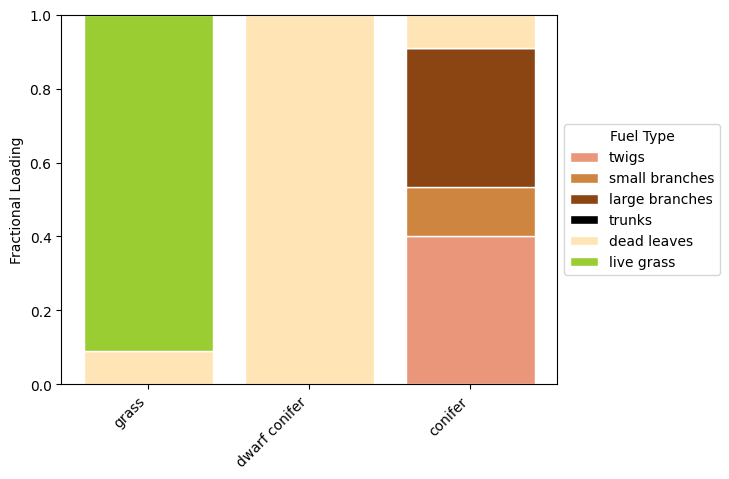

In [69]:
import matplotlib.pyplot as plt
import numpy as np

fuel_names = ['grass', 'dwarf conifer', 'conifer']

colors = [
    "darksalmon",
    "peru",
    "saddlebrown",
    "black",
    "moccasin",
    "yellowgreen",
]
fuel_types = [
    "twigs",
    "small branches",
    "large branches",
    "trunks",
    "dead leaves",
    "live grass",
]

fractional_loadings = np.array([f.frac_loading for f in fuels])

n_fuels, n_classes = fractional_loadings.shape
x = np.arange(n_fuels)

fig, ax = plt.subplots()
bottom = np.zeros(n_fuels)

for i in range(n_classes):
    ax.bar(
        x,
        fractional_loadings[:, i],
        bottom=bottom,
        color=colors[i],
        edgecolor="white",
        label=fuel_types[i],
    )
    bottom += fractional_loadings[:, i]

ax.set_xticks(x)
ax.set_xticklabels(fuel_names, rotation=45, ha="right")
ax.set_ylabel("Fractional Loading")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Fuel Type");

The grass fuel is mostly live grass, with some dead leaves. The dwarf conifer fuel is completely dead leaves, and the conifer fuel is mostly woody debris with some dead leaves.

Based on what we know about fuel types, we would expect the dwarf conifer litter to have the highest SAV, the conifer litter to have the lowest SAV, and the grass litter to be in between.

Let's take a look at the SAV values for these fuels:

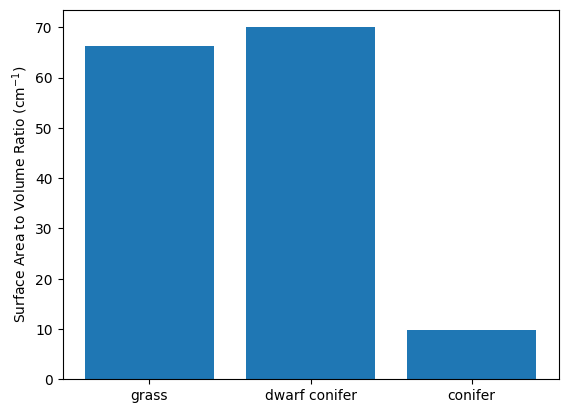

In [70]:
# grab SAV values
sav_values = [fuel.sav_notrunks for fuel in fuels]

plt.bar(fuel_names, sav_values)
plt.ylabel("Surface Area to Volume Ratio (cm$^{-1}$)");

#### Questions to explore:
* Does this look correct given what we know about the fuel?
* What could we do if there was a discrapancy?
---

## Exercise 2.2: Comparing bulk density

Use what you have learned to similarly compare the bulk density of the fuels (`fuel.bulk_density_notrunks').

In [71]:
#TODO: plot the bulk density comparison

## Exercise 2.3: Testing the fraction burnt method

Let's move on to testing a method of the `Fuel` class.

The `calculate_fraction_burnt` method should satisfy the following properties:

0 <= `frac_burnt` <= 1

Increasing moisture reduces `frac_burnt` for each fuel class.

Maximum fraction burnt for grasses is capped.

This method only takes `effective_moisture` so we can just use one fuel object to test it. We will set the effective moisture to some dummy values.

In [95]:
fuel = fuels[0]
fuel.effective_moisture = np.array([0.12, 0.18, 0.25, 0.5, 0.05, 0.7])

fuel.calculate_fraction_burnt()

print("Fraction burnt:", fuel.frac_burnt)

Fraction burnt: [0.945     0.907578  0.7252875 0.378     0.945     0.67662  ]


### Property check
Are all the values between 0.0 and 1.0?

### Visual check

Text(0, 0.5, 'Fraction burnt')

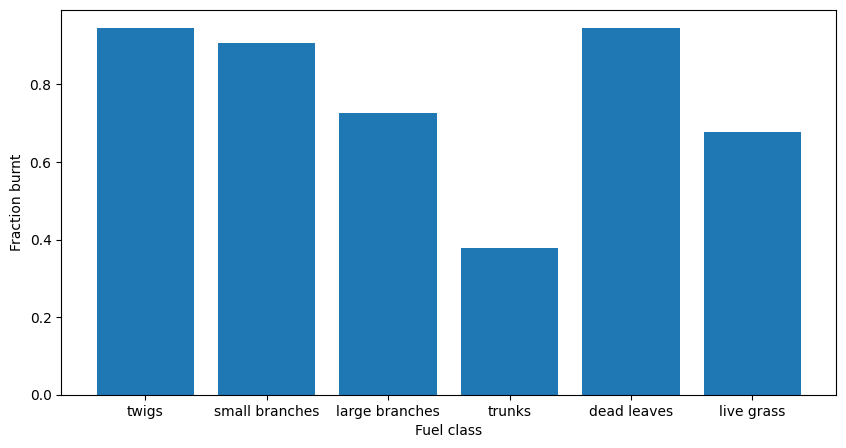

In [73]:
plt.subplots(figsize=(10,5))
plt.bar(fuel_types, fuel.frac_burnt)
plt.xlabel("Fuel class")
plt.ylabel("Fraction burnt")

Increase `effective_moisture` of each fuel by 0.05. Does `frac_burnt` decrease as expected? Plot the difference.

In [74]:
## TODO: Investigate increasing effective_moisture

Now let's investigate the `frac_burnt` across all possible values of `effective_moisture`. Set the same moisture value for all the fuel types (i.e. the entire `fuel.effective_moisture` array).

In [100]:
moisture = np.linspace(0.00, 1.0, 20)

# create a dict to store results for each fuel type
results = {ftype: [] for ftype in fuel_types}

# for moist in moisture:
    # TODO: update fuel.effective_moisture and calculate fraction burnt
    
    # TODO: record results for each fuel type
    # for i, ftype in enumerate(fuel_types):

# TODO: plot output

---
## What We Just Did
* Used the `Fuel` class, making sure to check the initial values for utility and realism
* Utilized methods of the `Fuel` class to plot method outputs across a range of values

---

## Looking Ahead
Next we will:
* Understand how to use input driver data to drive a small test